# Simulation code

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time

## Non-linear models

These three models transform the vector of explanatory variables $S_t$ into a vector of nonlinear transformed variables $G(S_t;\varphi)$.

In [2]:
def TR_model(S_t, gamma):
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

## Test statistics TR

In [44]:
def cal_g_theta_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create an array of gamma value that are used in the for loop
    gamma_quantile = np.linspace(0.15,0.85,grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TR_model(S_t,np.quantile(S_t,gamma_quantile[i])))))
                                                                     for i in range(grid_elements)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]


    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    plt.hist(lambda_P.reshape(-1),bins=100)
    plt.show()
    
    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    plt.plot(crit_values)
    plt.show()
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1,g_theta,final_crit_value
    else:
        return 0,g_theta,final_crit_value

## Test statistics LSTR

In [4]:
def cal_g_theta_LSTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     LSTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1,g_theta,final_crit_value
    else:
        return 0,g_theta,final_crit_value

## Test statistics ESTR


In [5]:
def cal_g_theta_ESTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     ESTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1,g_theta,final_crit_value
    else:
        return 0,g_theta,final_crit_value

## Simulation 1

In [6]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

In [7]:
def MonteCarlo_1(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_1)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], _, _ = MonteCarlo_iteration_1(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_1(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the corresponding lost function of interest
        delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size,T_size)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)

    
def sim_model_1(T_size):

    # Initialize delta1, delta2 and v
    delta1 = delta2 = v = 1

    # Simulate the model
    z1 = np.random.normal(0,1,(T_size,1))
    z2 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z1 + delta2 * z2 + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size):
    
    # Compile z1 and z2
    sim_z1 = np.column_stack([np.ones((T_size,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T_size,1)),sim_z2])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z1_sel = sim_z1[t-R_size:t]
        z2_sel = sim_z2[t-R_size:t]
        y_sel = sim_y_t[t-R_size:t]
        
        # Estimate the linear regression estimates
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        # Estimate the two forecasts
        forecast1 = beta_1[0] + z1_sel[-1,1] * beta_1[1]
        forecast2 = beta_2[0] + z2_sel[-1,1] * beta_2[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (y_sel[-1] - forecast1)**2 - (y_sel[-1] - forecast2)**2
    
    # Return the vector of the loss function of interest
    return delta_L

In [8]:
#simulation speed:
MC_iterations = 100
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = True
barlett_kernel = False

print("---TR model---")
model_type = "TR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---LSTR model---")
model_type = "LSTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---ESTR model---")
model_type = "ESTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))

---TR model---
For R = 25
And P = 50


KeyboardInterrupt: 

In [9]:
def MonteCarlo_1_analyse(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_1)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        g_theta_array = np.array([result[1] for result in Results])
        crit_value_array = np.array([result[2] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        g_theta_array = np.zeros(MC_iterations)
        crit_value_array = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], g_theta_array[i], crit_value_array[i] = MonteCarlo_iteration_1(R,P,T)    
    
    sns.scatterplot(x=crit_value_array,y=g_theta_array,s=13,color='mediumblue')
    sns.lineplot(x=[-100,100],y=[-100,100],color='red',linestyle='--')
    plt.xlim(5.3,12.7)
    plt.ylim(-0.5,30.5)
    plt.xlabel("Critital Value")
    plt.ylabel("Test Statistic")
    plt.show()

C:\Users\joche\AppData\Local\Temp\ipykernel_5640\72825377.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i], g_theta_array[i], crit_value_array[i] = MonteCarlo_iteration_1(R,P,T)


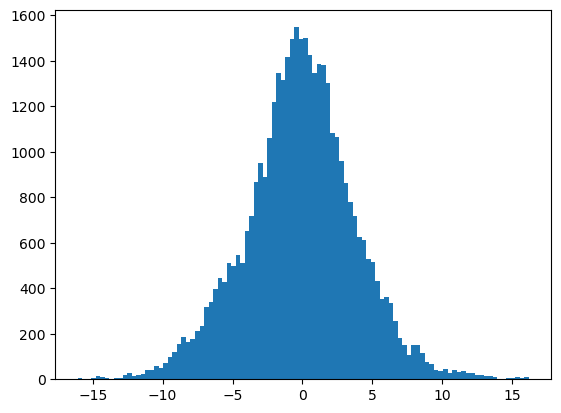

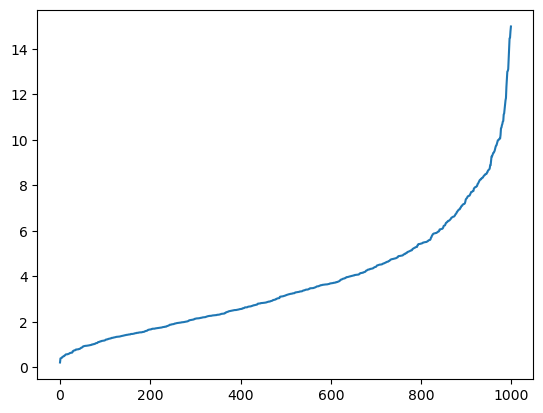

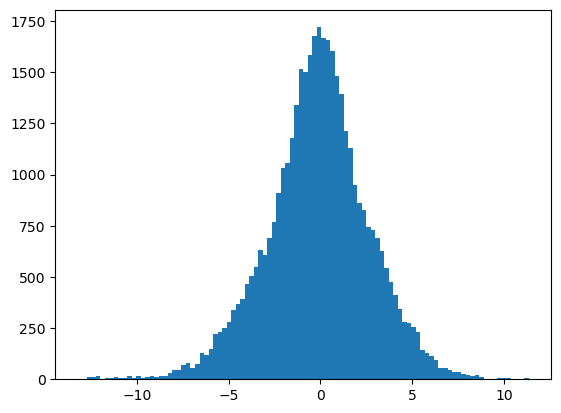

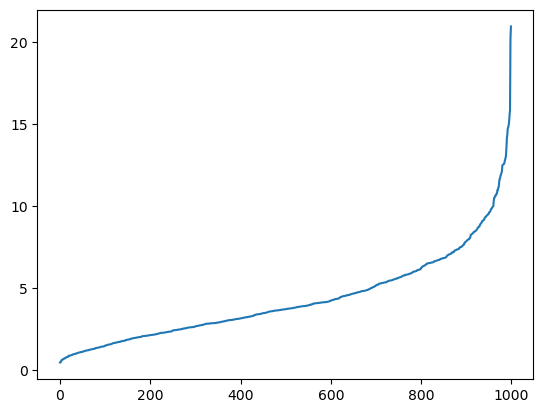

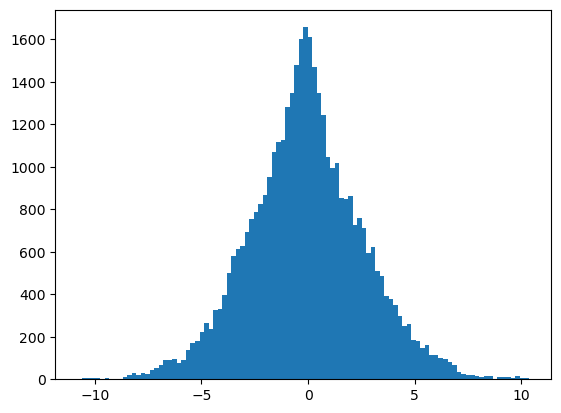

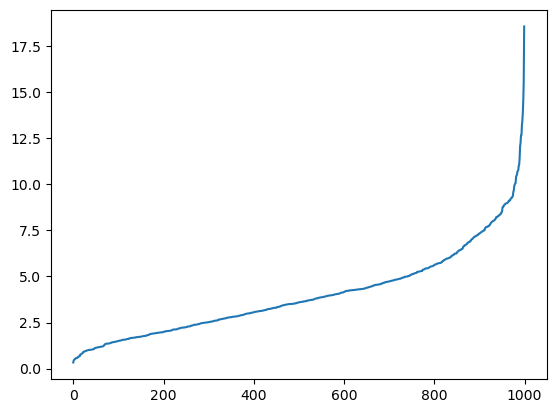

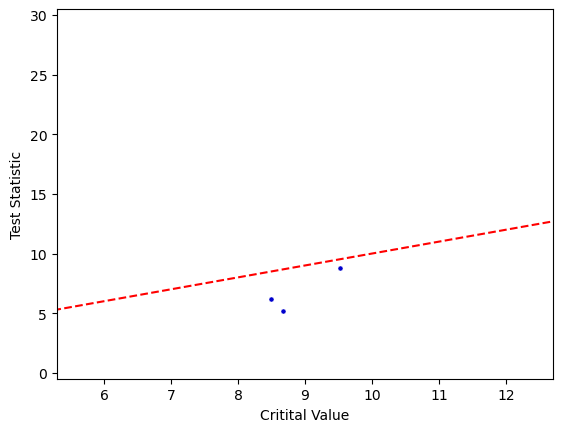

C:\Users\joche\AppData\Local\Temp\ipykernel_5640\72825377.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i], g_theta_array[i], crit_value_array[i] = MonteCarlo_iteration_1(R,P,T)


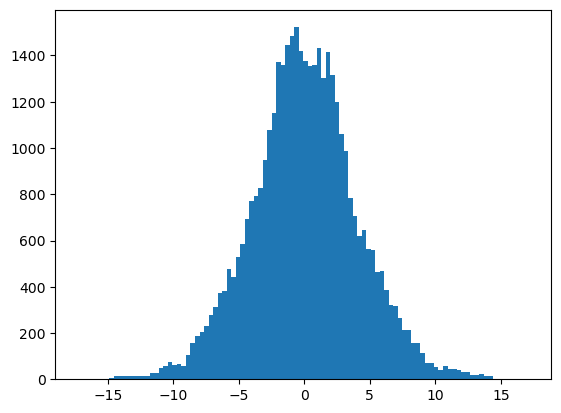

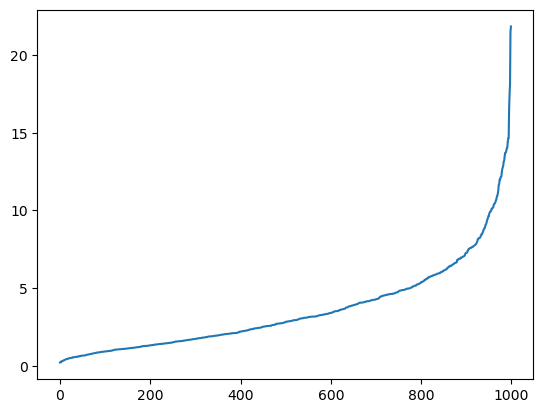

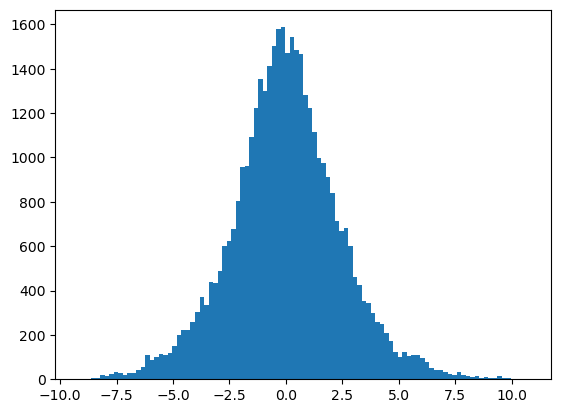

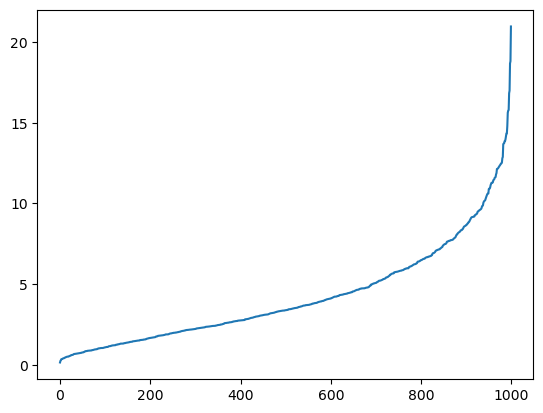

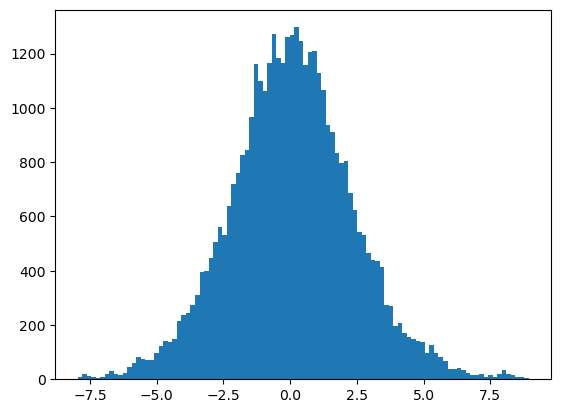

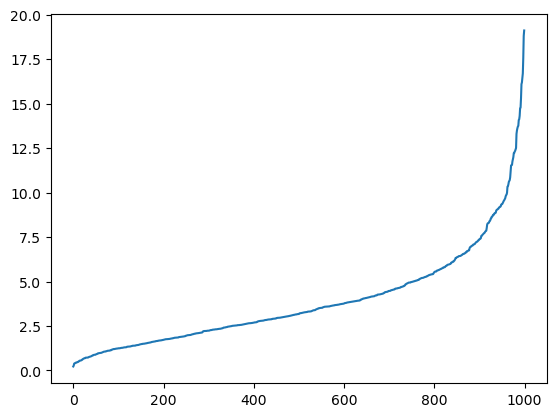

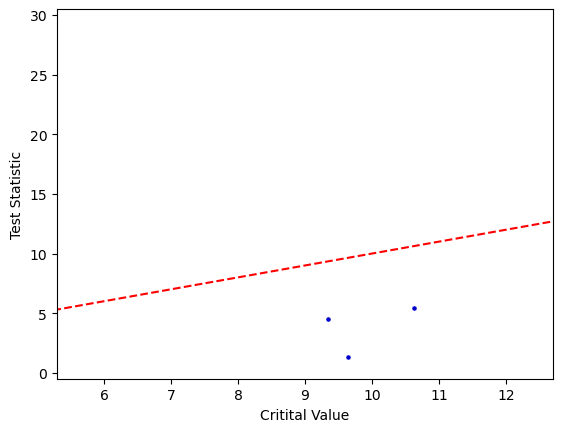

In [45]:
#simulation speed:
MC_iterations = 3
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Adjustable variables
parallelization = False
barlett_kernel = False

model_type = "TR"

# Values for P, R and T
R_MC = 50
P_MC = 50
T_MC = R_MC + P_MC

MonteCarlo_1_analyse(R_MC,P_MC,T_MC)

barlett_kernel = True
# # Values for P, R and T
# R_MC = 50
# P_MC = 200
# T_MC = R_MC + P_MC

MonteCarlo_1_analyse(R_MC,P_MC,T_MC)

# Simulation 2

In [7]:
def MonteCarlo_2(R_size,P_size,T_size,c):
    
    if (parallelization == True):
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_2)(R_size,P_size,T_size,c) for i in range(MC_iterations))
    
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        
    else:
        MC_array =np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], _, _ = MonteCarlo_iteration_2(R_size,P_size,T_size,c)    
    
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_2(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_2(delta_L_1,sim_S_t[R_size-1:T_size-1],c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)


def cal_delta_L_2(delta_L_old,S_sel,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)
    
    # Return the loss function of interest
    return delta_L

In [135]:
# First, we want to determine the significance level for size-adjustment

# Global variables that determine the accuracy of the outcome
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Values for P to loop over
P_MC_array = [50,100,200]

# Initiliaze R and horizon h
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.014
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.013
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 100
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.032
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

0.0
0.1
0.1
0.1
0.0
0.0
0.0
0.0
0.1


[0.055 0.198 0.641 0.948 0.998 1.    1.    1.    1.    1.    1.   ]
[0.058 0.185 0.614 0.926 0.997 1.    1.    1.    1.    1.    1.   ]
[0.045 0.18  0.61  0.92  0.997 1.    1.    1.    1.    1.    1.   ]


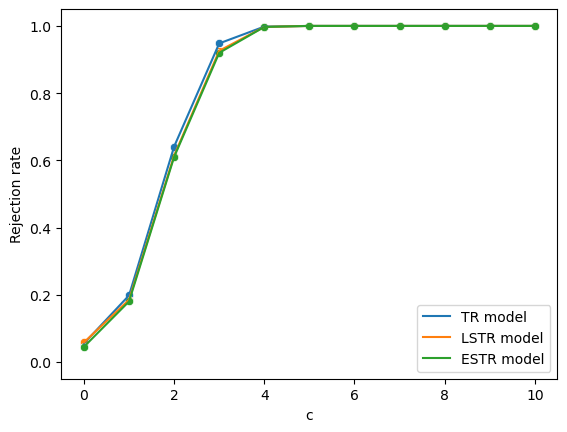

In [12]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 1000
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
P_MC_array = [50,100,200]
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(rejection_array)
sns.lineplot(rejection_array, label='TR model')
        
model_type = "LSTR"
signi_level = 0.014
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(rejection_array)
sns.lineplot(rejection_array, label='LSTR model')
        
model_type = "ESTR"
signi_level = 0.013
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(rejection_array)
sns.lineplot(rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(rejection_array)
sns.lineplot(rejection_array, label='TR model')
    
model_type = "LSTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(rejection_array)
sns.lineplot(rejection_array, label='LSTR model')
    
model_type = "ESTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(rejection_array)
sns.lineplot(rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

C:\Users\joche\AppData\Local\Temp\ipykernel_6124\4224551210.py:80: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  lam = [np.sum(np.absolute(cal_g_theta_TR(np.random.normal(0,1,(100,1)),np.random.normal(0,1,(50,1)),50,50,100))) for i in range(100)]


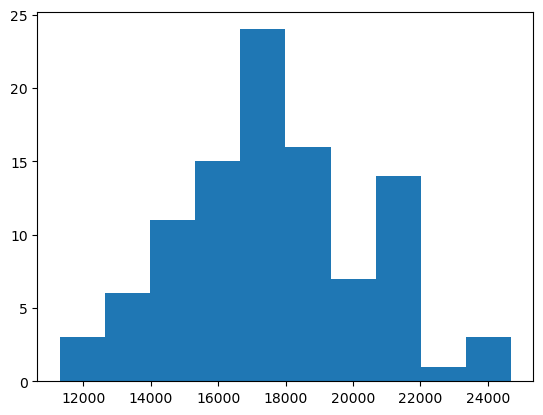

C:\Users\joche\AppData\Local\Temp\ipykernel_6124\4224551210.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  lam = [np.sum(np.absolute(cal_g_theta_TR(np.random.normal(0,1,(100,1)),np.random.normal(0,1,(50,1)),50,50,100))) for i in range(100)]


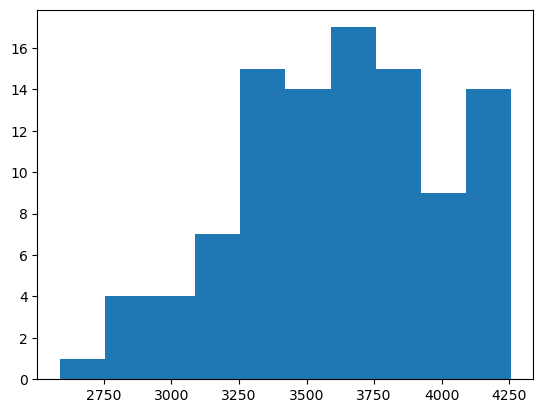

In [137]:
def cal_g_theta_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create an array of gamma value that are used in the for loop
    gamma_quantile = np.linspace(0.15,0.85,grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TR_model(S_t,np.quantile(S_t,gamma_quantile[i])))))
                                                                     for i in range(grid_elements)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
#     print(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
#                                                              for b in range(0,B_size+1)]),axis=0))
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size)**0.5),(0,2,1))
    return lambda_P

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1,g_theta,final_crit_value
    else:
        return 0,g_theta,final_crit_value

barlett_kernel = True

lam = [np.sum(np.absolute(cal_g_theta_TR(np.random.normal(0,1,(100,1)),np.random.normal(0,1,(50,1)),50,50,100))) for i in range(100)]
plt.hist(lam)
plt.show()

barlett_kernel = False

lam = [np.sum(np.absolute(cal_g_theta_TR(np.random.normal(0,1,(100,1)),np.random.normal(0,1,(50,1)),50,50,100))) for i in range(100)]
plt.hist(lam)
plt.show()

In [71]:
a = np.random.standard_t(2,1000)
b = np.random.standard_t(2,1000) + np.random.normal(0,1,1000) + np.random.normal(0,1,1000)
b = b / (3**0.5)
print(np.std(a))
print(np.std(b))
a = np.sort(a)
print(a[949])
b = np.sort(b)
b[949]

3.2288520067375535
1.9653898559056957
2.834403395981506


2.1528806719273996